https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data?select=sales_train.csv

In [8]:
%pip install neuralprophet
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib inline

from neuralprophet import NeuralProphet
import pandas as pd
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True
warnings.filterwarnings("ignore")

## Read the sales data into a dataframe

In [10]:
sales_df = pd.read_csv('data/dataset/sales_train.csv')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='mixed')

## Drop excess columns

In [11]:
# drop item_price and item_cnt_day
# sales_df = sales_df.drop(columns=['item_price', 'date_block_num'])

## Read Items and Categories 

In [12]:
# read item categories and items
items_df = pd.read_csv('data/dataset/items.csv')
categories_df = pd.read_csv('data/dataset/item_categories.csv')

## Join Items to Categories

In [13]:
# merge item categories and items
items_df = pd.merge(items_df, categories_df, on='item_category_id')

## Join Sales and Items

In [14]:
# combine sales and items
sales_df = pd.merge(sales_df, items_df, on='item_id')
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [15]:
# rename item_category_id to category
sales_df = sales_df.rename(columns={'item_category_id': 'category'})


# Drop Extra Columns

In [16]:
# Drop columns
sales_df = sales_df.drop(columns=['item_category_name', 'item_name', 'date_block_num', 'item_price'])

In [17]:
sales_df.head()

# # write csv file to disk
# sales_df.to_csv('data/dataset/sales_processed.csv', index=False)

,date,shop_id,item_id,item_cnt_day,category
0,2013-02-01,59,22154,1.0,37
1,2013-03-01,25,2552,1.0,58
2,2013-05-01,25,2552,-1.0,58
3,2013-06-01,25,2554,1.0,58
4,2013-01-15,25,2555,1.0,56


# Group the sales by categories and date

In [18]:
# Group the sales by date and category and sum up the sales from item_cnt_day column
sales_category_df = sales_df.groupby(['date', 'category'])['item_cnt_day'].sum().reset_index()
sales_category_df = sales_category_df.rename(columns={'date': 'ds', 'item_cnt_day': 'y'})

In [ ]:
# Build prophet models for each category
models = {}

for category in sales_category_df['category'].unique():
    category_df = sales_category_df[sales_category_df['category'] == category]
    category_df = category_df[['ds', 'y']]
    
    # drop rows with negative values in y
    category_df = category_df[category_df['y'] >= 0]
    category_df = category_df.sort_values('ds')
    
    # Check if the dataframe has at least 2 non-NaN rows
    if category_df.dropna().shape[0] < 2:
        continue
    
    model = NeuralProphet()
    model.set_plotting_backend("plotly-static")
    model.fit(category_df)
    forecast = model.predict(category_df)

    # Plot positive forecasts only
    #forecast.loc[forecast['yhat'] < 0, 'yhat'] = 0
    models[category] = (model, forecast)

    # Label the plot with the category
    # model.plot(forecast).gca().set_title(category)

import matplotlib.pyplot as plt # type: ignore

# Number of plots
num_plots = len(models)

# Create a grid of subplots with 4 plots per row
fig, axes = plt.subplots(nrows=(num_plots + 3) // 4, ncols=4, figsize=(20, 5 * ((num_plots + 3) // 4)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each forecast in the grid
for i, (category, (model, forecast)) in enumerate(models.items()):
    model.plot(forecast, ax=axes[i])
    axes[i].set_title(category)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
# Map shop_id from 1 to 10 to 0, 11 to 50 to 1, and 51 to 60 to 2
sales_df.loc[sales_df['shop_id'].between(1, 10), 'shop_id'] = 0
sales_df.loc[sales_df['shop_id'].between(11, 50), 'shop_id'] = 1
sales_df.loc[sales_df['shop_id'].between(51, 60), 'shop_id'] = 2
sales_df['shop_id'].unique()

array([2, 1, 0])

# Group the sales by Channel / store_id and date

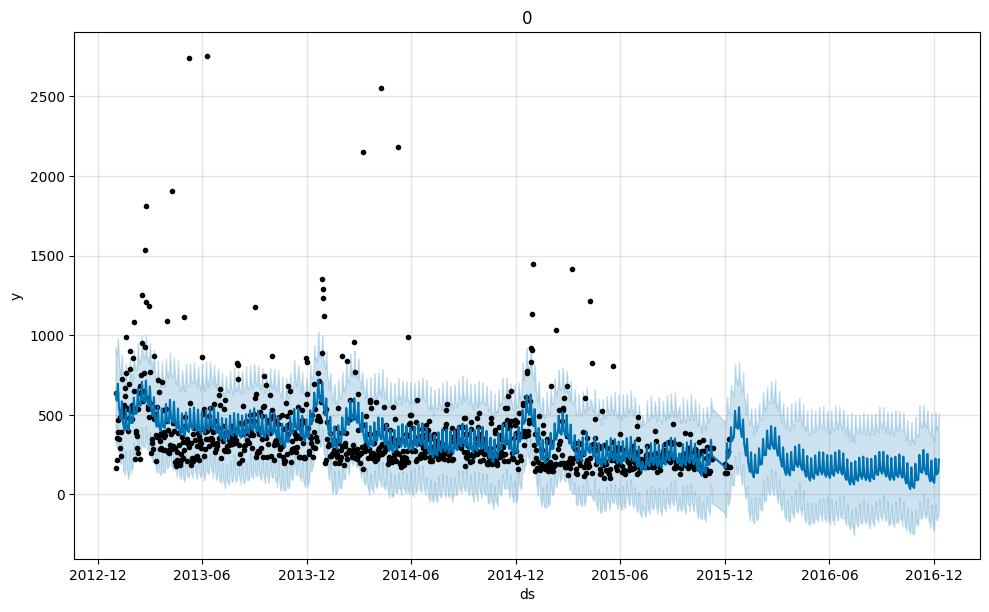

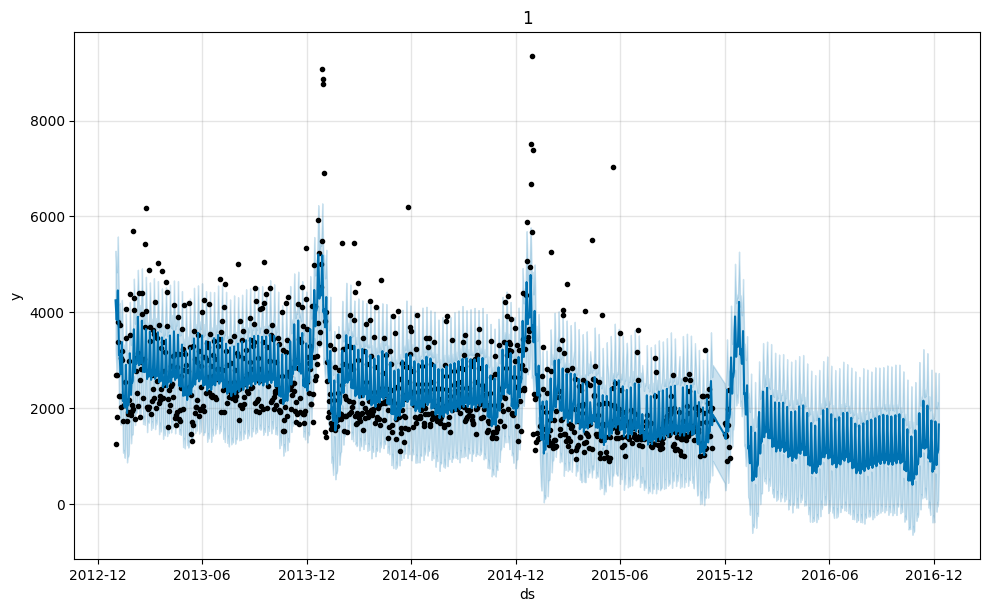

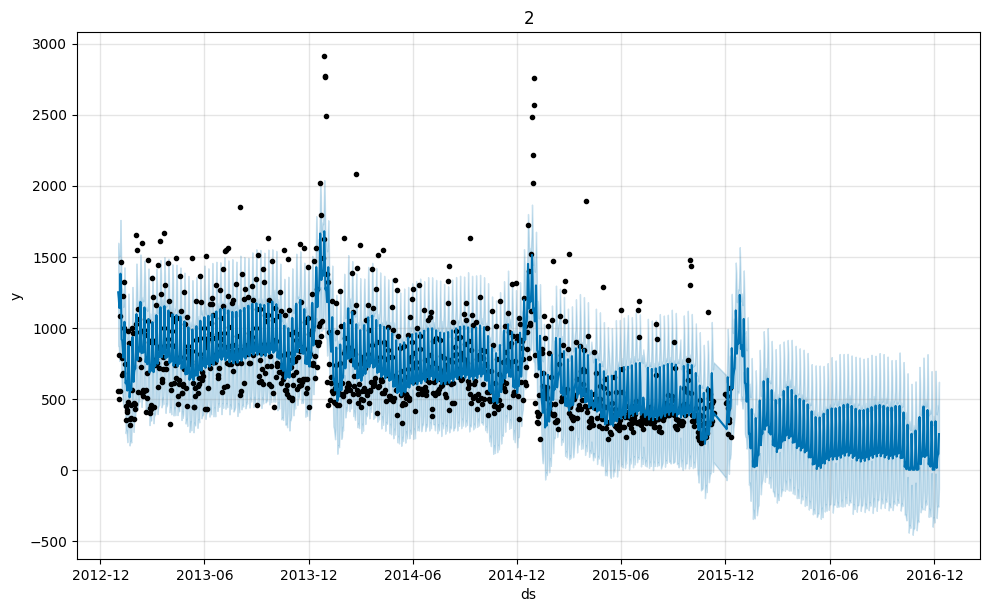

In [15]:
# Group the sales by date and category and sum up the sales from item_cnt_day column
sales_channel_df = sales_df.groupby(['date', 'shop_id'])['item_cnt_day'].sum().reset_index()

# Build prophet models for each channel
models = {}

for channel in sales_channel_df['shop_id'].unique():
    channel_df = sales_channel_df[sales_channel_df['shop_id'] == channel]
    # rename date to ds and item_cnt_day to y
    channel_df = channel_df.rename(columns={'date': 'ds', 'item_cnt_day': 'y'})
    channel_df = channel_df[['ds', 'y']]
    
    # drop rows with negative values in y
    channel_df = channel_df[channel_df['y'] >= 0]
    channel_df = channel_df.sort_values('ds')
    
    # Check if the dataframe has at least 2 non-NaN rows
    if channel_df.dropna().shape[0] < 2:
        continue
    
    model = Prophet()
    model.fit(channel_df)
    forecast = model.predict(model.make_future_dataframe(periods=365))

    # Plot positive forecasts only
    forecast.loc[forecast['yhat'] < 0, 'yhat'] = 0
    models[channel] = (model, forecast)

    # Label the plot with the category
    model.plot(forecast).gca().set_title(channel)